In [610]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv",index_col='City')
df.head()
cities = df.index

df = df.astype({'Assault':'float','UrbanPop':'float'})

labels =df.columns

correlations = df.corr('pearson')
print(correlations)

          Murder  Assault  UrbanPop  Rape
Murder     1.000    0.802     0.070 0.564
Assault    0.802    1.000     0.259 0.665
UrbanPop   0.070    0.259     1.000 0.411
Rape       0.564    0.665     0.411 1.000


In [565]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))
#To set the decimal precision:
#pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

Number of cases: 50 Number of features: 4


,mean,std,min,max
Murder,7.788,4.356,0.800,17.400
Assault,170.760,83.338,45.000,337.000
UrbanPop,65.540,14.475,32.000,91.000
Rape,21.232,9.366,7.300,46.000


In [566]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [611]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     float64
 2   UrbanPop  50 non-null     float64
 3   Rape      50 non-null     float64
dtypes: float64(4)
memory usage: 2.0+ KB


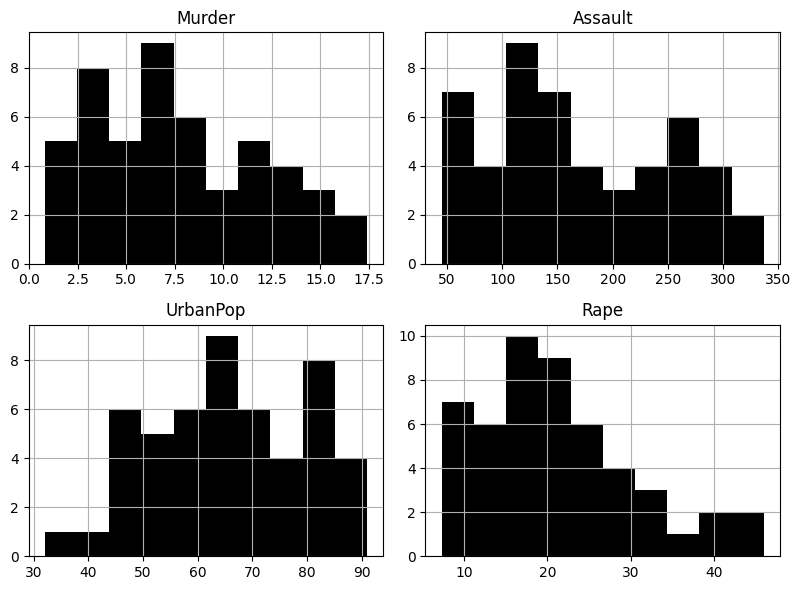

In [568]:
histograms = df.hist(color='black', grid=True, figsize=(8, 6)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

In [569]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary


,missing,mean,std,min,max
Murder,0,7.788,4.356,0.800,17.400
Assault,0,170.760,83.338,45.000,337.000
UrbanPop,0,65.540,14.475,32.000,91.000
Rape,0,21.232,9.366,7.300,46.000


From the above analysis we can see there is no missing data.  Let's now look at the correlation and scatter plots for all combinations of the variables.

In [570]:
cities = df.index
corr_df = df.corr()
labels =corr_df.columns
print(corr_df)
corr_df_sum=corr_df.sum().sort_values(ascending=True)
print(corr_df_sum)

          Murder  Assault  UrbanPop  Rape
Murder     1.000    0.802     0.070 0.564
Assault    0.802    1.000     0.259 0.665
UrbanPop   0.070    0.259     1.000 0.411
Rape       0.564    0.665     0.411 1.000
UrbanPop   1.740
Murder     2.435
Rape       2.640
Assault    2.726
dtype: float64


From the above correlation analysis we can basically extract 1 from the totals and divide by 3 to give an average correlation with the other 3 features. UrbanPop is very weak whereas Rape and Assualt are strong.  Assualt is the strongest.  UrbanPop is the weakest and only really has a significant correlation against Rape. 

<AxesSubplot: >

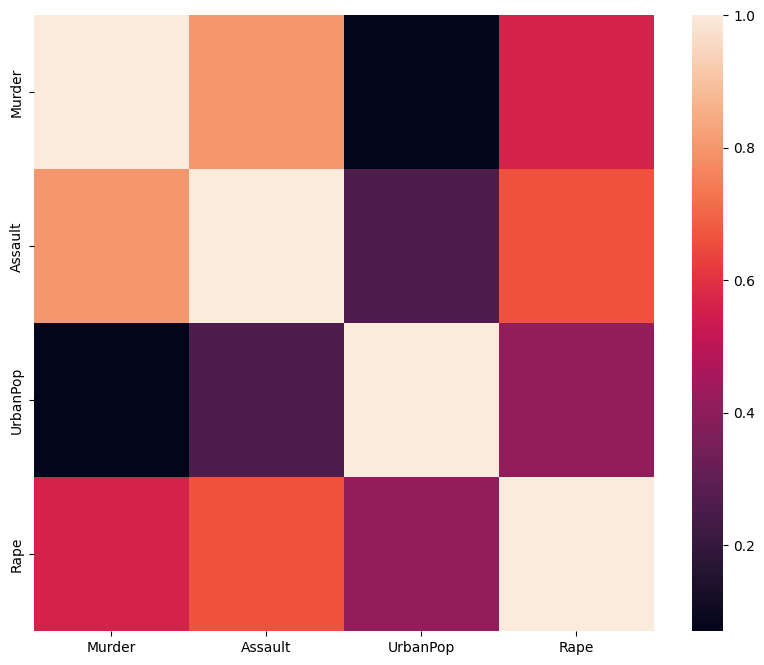

In [571]:
import seaborn as sns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(df.corr())


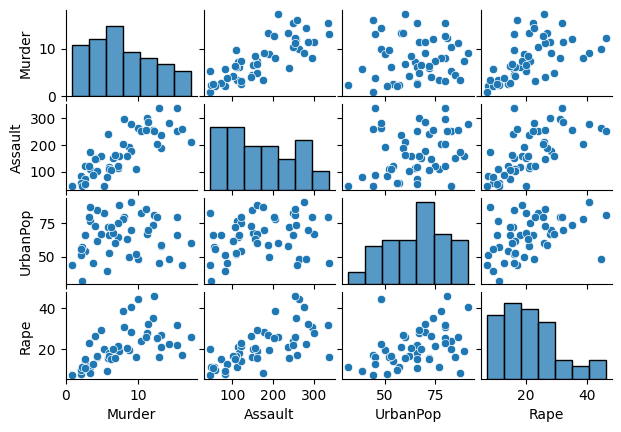

In [572]:
#figsize=(4, 4)
plt.rcParams['figure.figsize']=5,5
sns.pairplot(df).fig.set_size_inches(6,4)

From our four numerical features in the data, none have negative correlations which is why the correlation map starts from a scale of 0.  Of the combinations of these variables producing reasonably positivie results, Rape has a fairly consistent positive correlation with the other 3.  Assault and Murder combined produces the strongest paired correlation, which is perhaps not surprising.  UrbanPop seems to the least determinable feature here in that it only has a reasonable postitive correlation against Rape.  I am guessing that for this reason it will have a strong influence on the PCA process.  

## PCA Analysis

In [609]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)
X = df.values.squeeze()
pca = PCA()
X_trans = pca.fit_transform(X)
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


In [574]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Standard deviation: [83.73 14.21  6.49  2.48]
Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]
Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [575]:
feat_df=pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


We can see here that the features influencing PC1 and PC2 are dominated by two separate features.  For PC1, Assualt is by far the most dominating feature.  This is probably because it correlates well with almost all features, where as in PC2 UrbanPop is the considerable dominant feature with Rape playing a marginal influence.  This is because it doesn't particualry correlate well with any features except Rape, which may explain why rape also has a reasonable strong influence with a value of 0.2.  So in summary, PC1 is dominated by Assault which is the strongest corrrelating feature and PC2 is dominated by UprbanPop which is a poor correlator except with Rape that also influences PC2.

In [576]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    #plt.figure.figsize(8,8)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.rcParams["figure.figsize"] = (10,8)
    plt.grid()

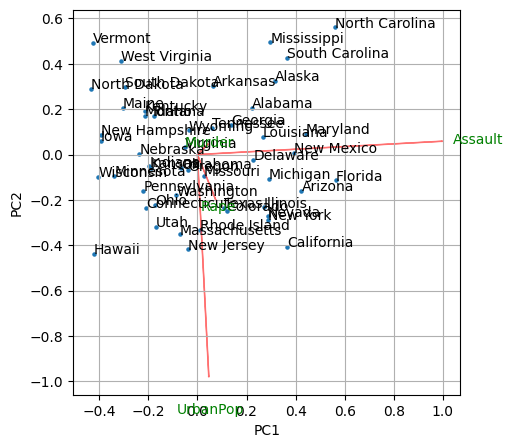

In [577]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

From the above BiPlot we can clarly see that Assualt and UrbanPop are the most important features as described before.  Also you can see that Rape is further away from the intersection of the two red lines than Murder indicating it has higher influence on the PC's than Murder.

### Standardised data

We standardise the data so that some features do not swamp the others.

In [578]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


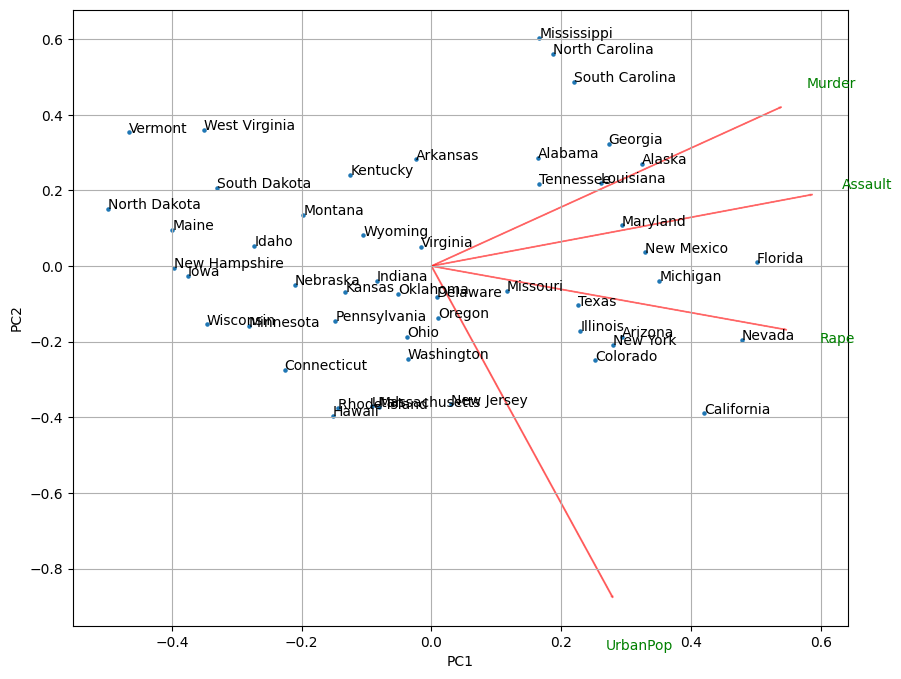

In [579]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

We see that the standardised data results in far more involvement of the Rape and Murder features being utilised to explain the variance. We also see that the different labels (Cities) are more obviously clustered together in groups unlike in the previous BiPlot.

Text(0.5, 1.0, 'Cumulative Explained Variance')

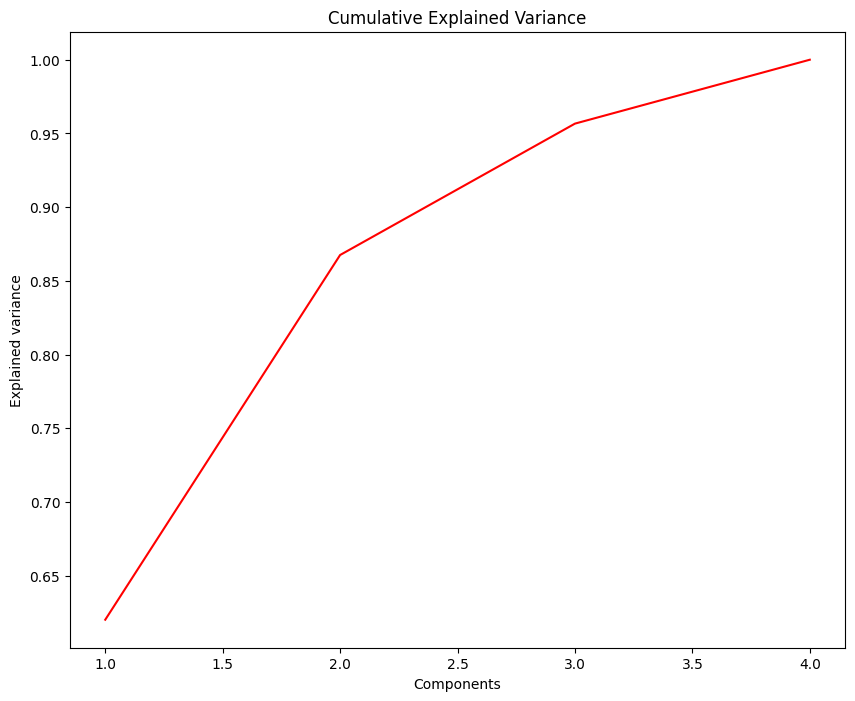

In [580]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

                0      1      2      3
City                                  
Alabama     0.986  1.133 -0.444  0.156
Alaska      1.950  1.073  2.040 -0.439
Arizona     1.763 -0.746  0.055 -0.835
Arkansas   -0.141  1.120  0.115 -0.183
California  2.524 -1.543  0.599 -0.342


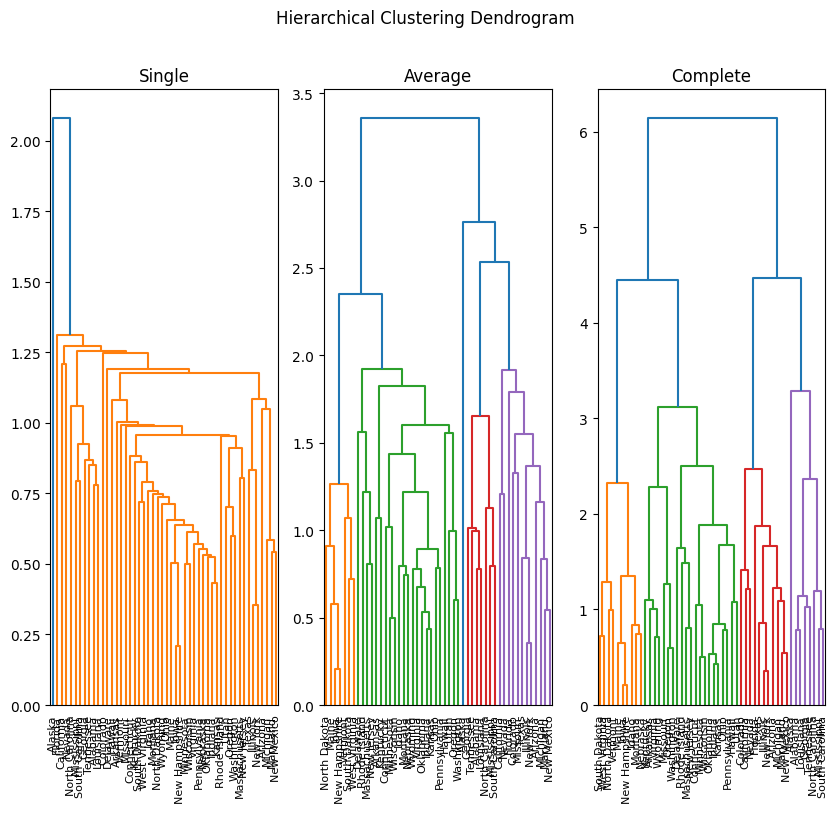

In [581]:


pca_df = pd.DataFrame(X_std_trans[:,0:5], index = df.index)
print(pca_df.head())
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

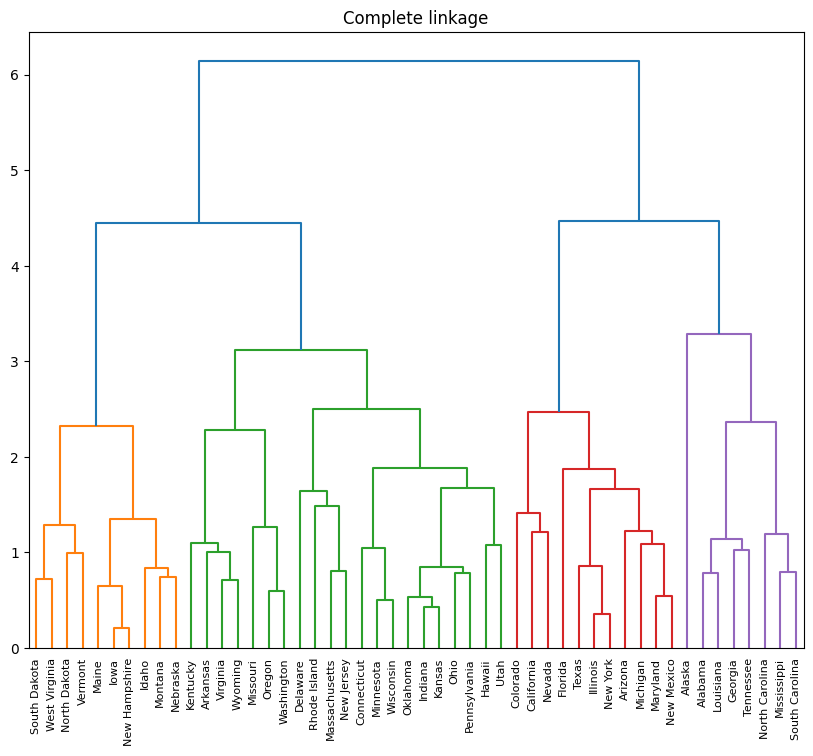

In [582]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

Build a dataframe containing the labels (City's) with their cluster groupings.  In this case they are called C1, C2, C3 and C4.

In [591]:

city_dend=dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)['ivl']
cluster_dend = dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)['leaves_color_list']
df_dend = pd.DataFrame([city_dend, cluster_dend],index=['City', 'Cluster']).T
df_dend


,City,Cluster
0,South Dakota,C1
1,West Virginia,C1
2,North Dakota,C1
3,Vermont,C1
4,Maine,C1
5,Iowa,C1
6,New Hampshire,C1
7,Idaho,C1
8,Montana,C1
9,Nebraska,C1


K-Means clustering on the standardised data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


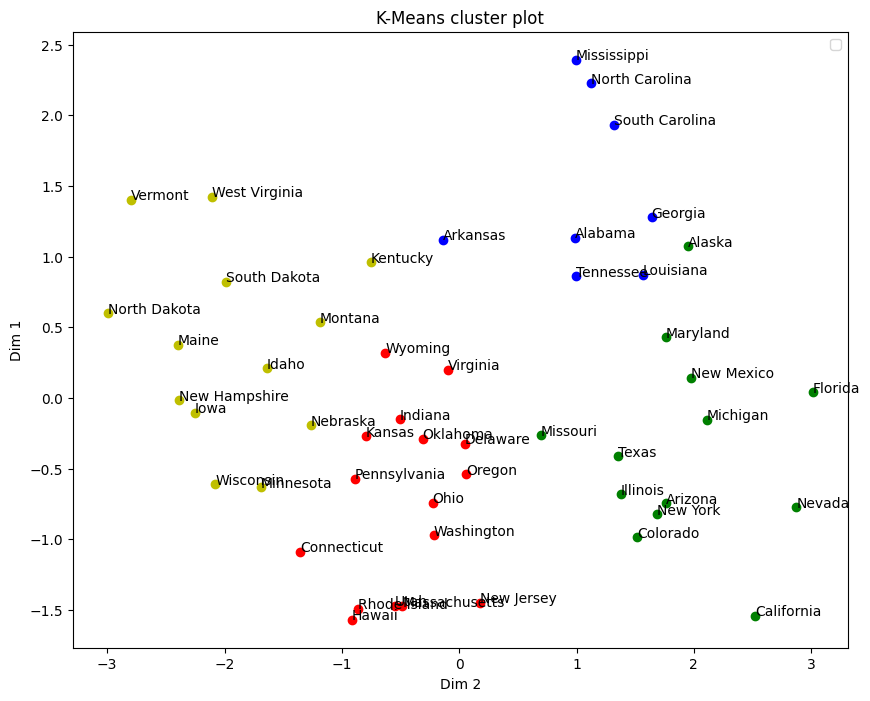

In [604]:
from sklearn.cluster import KMeans

# We extract the first two components

x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

## Analysis of the 2 different clusterings

In order to analyse the 2 clusterings I am going to obtain a list of City's where the the two techniques differered.  I will then look at those cities and see if there are any common characteristics.


In [638]:

c_cities = cities.values.reshape(-1,1)
c_cluster_labels = cluster_labels.reshape(-1,1)

c_combined =np.concatenate((c_cities,c_cluster_labels),axis=1)
dfKmeans=pd.DataFrame(c_combined,columns=['City','Cluster'])

df_dend.set_index('City')
df_dend.sort_values(by=['City'], inplace=True)
dfKmeans.set_index('City')
dfKmeans.sort_values(by=['City'], inplace=True)

df_dendK_compare=pd.merge(df_dend,dfKmeans,on='City')
anomaly_cities=['Alaska','Arkansas','Kentucky','Minnesota','Missouri','Wisconsin'] 
anomaly_df =df[df.index.isin(anomaly_cities)] 
print(anomaly_df)
df_dendK_compare['Combine'] = df_dendK_compare["Cluster_y"].astype(str) +  df_dendK_compare["Cluster_x"]

print('Combined Categories For All 50')
print(df_dendK_compare['Combine'].value_counts())
anomaly_cats = ['3C2','2C4','1C2','2C2'] 

temp_df = df_dendK_compare[df_dendK_compare['Combine'].isin(anomaly_cats)]
print(temp_df)


           Murder  Assault  UrbanPop   Rape
City                                       
Alaska     10.000  263.000    48.000 44.500
Arkansas    8.800  190.000    50.000 19.500
Kentucky    9.700  109.000    52.000 16.300
Minnesota   2.700   72.000    66.000 14.900
Missouri    9.000  178.000    70.000 28.200
Wisconsin   2.600   53.000    66.000 10.800
Combined Categories For All 50
0C2    16
2C3    11
3C1    10
1C4     7
3C2     3
2C4     1
1C2     1
2C2     1
Name: Combine, dtype: int64
         City Cluster_x Cluster_y Combine
1      Alaska        C4         2     2C4
3    Arkansas        C2         1     1C2
16   Kentucky        C2         3     3C2
22  Minnesota        C2         3     3C2
24   Missouri        C2         2     2C2
48  Wisconsin        C2         3     3C2


From the analysis above a total of 44 out of 50 cities were categorised in the same way in both models.   Of the 6 that were categorised differently, the predominate category that differed was C2 which appeared 5 times in the anomalies list.  C3 or C1 didn't appear and 0 didn't appear.

From the above city names and the Kmeans cluster map we can see Kentucky, Minnosota and Wisconsin cateogorised as 3 in the K-means clustering (category_y colour lime on the map) are all on the edge of the cluster.  This is also true of Missouri and Alaska in Kmeans category 2 (green) and Arkansas category 1 (blue).  In fact in the case of Arkansas, it really looks as though it belongs to category 3.

In summary of the Kmeans clustering analysis, all 6 cases in the anomalies list can visibility be seen as difficult to define in the Kmeans cluster map. 

In [640]:
print('Anomalies Data')
print(anomaly_df.describe())
print('All Cities')
print(selected_stats.T)

Anomalies Data
       Murder  Assault  UrbanPop   Rape
count   6.000    6.000     6.000  6.000
mean    7.133  144.167    58.667 22.367
std     3.501   80.153     9.688 12.316
min     2.600   53.000    48.000 10.800
25%     4.225   81.250    50.500 15.250
50%     8.900  143.500    59.000 17.900
75%     9.525  187.000    66.000 26.025
max    10.000  263.000    70.000 44.500
All Cities
      Murder  Assault  UrbanPop   Rape
mean   7.788  170.760    65.540 21.232
std    4.356   83.338    14.475  9.366
min    0.800   45.000    32.000  7.300
max   17.400  337.000    91.000 46.000


## Summary

Urban populations (UrbPop) for the 6 cities seem to be centred around the mean of all cities. Given this was the most indeterminable feature with the lowest correlation score against the other three variables, this would seem like the most obvious cause of the potential classification anomolie.  Assault in these cities seems generally quite low with a mean of 144 compared to 171 for all cities. Rape and murder seem to be close to the general mean.  Urban Population has a lower mean than all cities but also a very low std indicatating they are all not too far from the mean Urban Population for all cities.